In [ ]:
!pip install underthesea
!pip install gensim
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from underthesea import word_tokenize, pos_tag, sent_tokenize
import warnings
from gensim import corpora, models, similarities
import regex
from wordcloud import WordCloud, STOPWORDS
import pickle

In [ ]:
# pd.set_option('display.max_colwidth', None)  # Hiển thị toàn bộ nội dung cột

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Đọc dữ liệu

In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/LDS0_k296_NgoTrieuPhu/Projects_2/Data_Agoda/hotel_info.csv", encoding="utf-8", delimiter=',')
data.head(5)

,num,Hotel_ID,Hotel_Name,Hotel_Rank,Hotel_Address,Total_Score,Location,Cleanliness,Service,Facilities,Value_for_money,Comfort_and_room_quality,comments_count,Hotel_Description
0,1,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,5 sao trên 5,"60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam","8,8","9,4","8,9","8,9","8,7","8,7","8,3",1269,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...
1,2,1_2,ALPHA BIRD NHA TRANG,4 sao trên 5,"51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang,...","7,7","7,8","7,6","8,1","7,5","8,1",NaN,337,ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...
2,3,1_3,Khách sạn Aaron (Aaron Hotel),3.5 sao trên 5,"6Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam...","8,5","8,9","8,7","8,8","8,1","8,5",NaN,300,Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...
3,4,1_4,Panorama Star Beach Nha Trang,5 sao trên 5,"02 Nguyen Thi Minh Khai, Lộc Thọ, Nha Trang, V...","8,8","9,6","8,9","8,9","8,7","9,0",NaN,814,Panorama Star Beach Nha Trang - Một kỳ nghỉ tu...
4,5,1_5,Khách sạn Balcony Nha Trang (Balcony Nha Trang...,4 sao trên 5,"98B/13 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam","8,4","8,5","8,7","8,5","8,3","8,6","8,7",294,Khách sạn Balcony Nha Trang - Nơi nghỉ dưỡng t...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   num                       740 non-null    int64 
 1   Hotel_ID                  740 non-null    object
 2   Hotel_Name                740 non-null    object
 3   Hotel_Rank                740 non-null    object
 4   Hotel_Address             740 non-null    object
 5   Total_Score               740 non-null    object
 6   Location                  413 non-null    object
 7   Cleanliness               412 non-null    object
 8   Service                   373 non-null    object
 9   Facilities                370 non-null    object
 10  Value_for_money           410 non-null    object
 11  Comfort_and_room_quality  51 non-null     object
 12  comments_count            740 non-null    int64 
 13  Hotel_Description         739 non-null    object
dtypes: int64(2), object(12)
me

# Tạo dataframe để đối chiếu lấy recommend sau khi có matrix

In [ ]:
data_recommend = data[['Hotel_ID', 'Hotel_Name' ,'Hotel_Description', 'Hotel_Address']]
data_recommend.head(5)

,Hotel_ID,Hotel_Name,Hotel_Description,Hotel_Address
0,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...,"60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam"
1,1_2,ALPHA BIRD NHA TRANG,ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...,"51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang,..."
2,1_3,Khách sạn Aaron (Aaron Hotel),Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...,"6Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam..."
3,1_4,Panorama Star Beach Nha Trang,Panorama Star Beach Nha Trang - Một kỳ nghỉ tu...,"02 Nguyen Thi Minh Khai, Lộc Thọ, Nha Trang, V..."
4,1_5,Khách sạn Balcony Nha Trang (Balcony Nha Trang...,Khách sạn Balcony Nha Trang - Nơi nghỉ dưỡng t...,"98B/13 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam"


In [ ]:
data_recommend[data_recommend.isnull().any(axis=1)]

,Hotel_ID,Hotel_Name,Hotel_Description,Hotel_Address
389,38_29,"Biệt thự 500 m² 5 phòng ngủ, 4 phòng tắm riêng...",NaN,"Vĩnh Trường, Nha Trang, Việt Nam"


In [ ]:
data_recommend.drop_duplicates(inplace=True)
data_recommend.dropna(inplace=True)
data_recommend.info()

<class 'pandas.core.frame.DataFrame'>
Index: 739 entries, 0 to 739
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Hotel_ID           739 non-null    object
 1   Hotel_Name         739 non-null    object
 2   Hotel_Description  739 non-null    object
 3   Hotel_Address      739 non-null    object
dtypes: object(4)
memory usage: 28.9+ KB


<ipython-input-9-63b85f4feeee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_recommend.drop_duplicates(inplace=True)
<ipython-input-9-63b85f4feeee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_recommend.dropna(inplace=True)


In [ ]:
!pip install langdetect
from langdetect import detect

def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=59324a37b52d7faa0953416ddf4bcbf8e5619097a0dac7d848ace8e917eef763
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
data_recommend['Language'] = data_recommend['Hotel_Description'].apply(detect_language)
data_recommend = data_recommend[data_recommend['Language'] == 'vi']

<ipython-input-11-2e02b03a72cc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_recommend['Language'] = data_recommend['Hotel_Description'].apply(detect_language)


In [ ]:
data_recommend.count()

,0
Hotel_ID,586
Hotel_Name,586
Hotel_Description,586
Hotel_Address,586
Language,586


# Tạo cột Index để đối chiếu lấy recommend sau khi có matrix

In [ ]:
data_recommend['Index'] = range(len(data_recommend))
data_recommend.head()

<ipython-input-13-f469e97f7584>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_recommend['Index'] = range(len(data_recommend))


,Hotel_ID,Hotel_Name,Hotel_Description,Hotel_Address,Language,Index
0,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...,"60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam",vi,0
1,1_2,ALPHA BIRD NHA TRANG,ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...,"51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang,...",vi,1
2,1_3,Khách sạn Aaron (Aaron Hotel),Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...,"6Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam...",vi,2
3,1_4,Panorama Star Beach Nha Trang,Panorama Star Beach Nha Trang - Một kỳ nghỉ tu...,"02 Nguyen Thi Minh Khai, Lộc Thọ, Nha Trang, V...",vi,3
4,1_5,Khách sạn Balcony Nha Trang (Balcony Nha Trang...,Khách sạn Balcony Nha Trang - Nơi nghỉ dưỡng t...,"98B/13 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam",vi,4


# Tạo dataframe mới để xử lý văn bản

In [ ]:
data_new = data_recommend.drop(['Hotel_Name', 'Language'], axis=1)
data_new.head()

,Hotel_ID,Hotel_Description,Hotel_Address,Index
0,1_1,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...,"60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam",0
1,1_2,ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...,"51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang,...",1
2,1_3,Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...,"6Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam...",2
3,1_4,Panorama Star Beach Nha Trang - Một kỳ nghỉ tu...,"02 Nguyen Thi Minh Khai, Lộc Thọ, Nha Trang, V...",3
4,1_5,Khách sạn Balcony Nha Trang - Nơi nghỉ dưỡng t...,"98B/13 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam",4


## Bỏ đi các ký tự, số sau 'Việt Nam' trong Hotel_Address

In [ ]:
pd.set_option('display.max_colwidth', None)  # Hiển thị toàn bộ nội dung cột

In [ ]:
# Regex để lấy phần trước 'Nha Trang'
regex = re.compile(r"^(.*?)(?:,\s*Nha Trang, Việt Nam)")

# Áp dụng regex cho cột 'Hotel_Address'
data_new['Hotel_Address'] = data_new['Hotel_Address'].apply(lambda x: regex.search(x).group(1).strip() if regex.search(x) else x)
data_new['Hotel_Address'].head()

,Hotel_Address
0,"60 Trần Phú, Lộc Thọ"
1,"51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang, Lộc Thọ"
2,"6Trần Quang Khải, Lộc Thọ"
3,"02 Nguyen Thi Minh Khai, Lộc Thọ"
4,"98B/13 Trần Phú, Lộc Thọ"


## Xử lý test bằng underthesea

In [ ]:
pd.reset_option('display.max_colwidth')

In [ ]:
data_new['Content'] = data_new.apply(lambda row: ' '.join((row['Hotel_Description']+ ' ' + row['Hotel_Address']).split()),axis=1)
data_new['Content']

,Content
0,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...
1,ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...
2,Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...
3,Panorama Star Beach Nha Trang - Một kỳ nghỉ tu...
4,Khách sạn Balcony Nha Trang - Nơi nghỉ dưỡng t...
...,...
735,Victor Condotel Cam Ranh Tận hưởng tất cả nhữn...
736,Victor Group - Sam Sam Cam Ranh Condotel Victo...
737,Victory's House Ngoc Hoa Victory's House Ngoc ...
738,Western Seaview (The Arena Cam Ranh) Western S...


In [ ]:
data_new["Content_wt"] = data_new["Content"].apply(lambda x: word_tokenize(x, format="text"))
data_new['Content_wt'] = data_new['Content_wt'].str.lower()
data_new[['Content','Content_wt']].head(2)

Content  \
0  Khách sạn Mường Thanh Luxury Nha Trang - Nơi lưu trú tuyệt vời tại Nha Trang Khách sạn Mường Thanh Luxury Nha Trang nằm ở trung tâm thành phố Nha Trang, Việt Nam, là một khách sạn 5 sao đẳng cấp. Với vị trí thuận lợi, khách sạn này chỉ cách trung tâm thành phố 0.2 km và cách sân bay khoảng 39 phút đi xe. Khách sạn Mường Thanh Luxury Nha Trang được xây dựng vào năm 2014 và hiện có tổng cộng 458 phòng. Với số lượng phòng lớn như vậy, khách sạn này đảm bảo sẽ đáp ứng được nhu cầu lưu trú của du khách một cách thoải mái và tiện nghi. Thời gian nhận phòng tại khách sạn là từ 02:00 PM và thời gian trả phòng là đến 12:00 PM. Điều này cho phép du khách có đủ thời gian để thư giãn và tận hưởng các tiện ích và dịch vụ tuyệt vời của khách sạn. Đặc biệt, cho phép trẻ em từ 6 đến 11 tuổi lưu trú miễn phí, tạo điều kiện thuận lợi cho các gia đình có trẻ nhỏ. tọa lạc tại Nha Trang, Việt Nam, mang đến cho du khách những tiện nghi giải trí tuyệt vời. Với nhiều cửa hàng đa dạng, khách sạn này đáp ứng mọi nhu cầu mua sắm của bạn. Nếu bạn muốn thử vận may, hãy ghé thăm sòng bạc của khách sạn để trải nghiệm những trò chơi độc đáo. Khách sạn cũng có một quầy bar thân thiện nơi bạn có thể thưởng thức những đồ uống thơm ngon và thư giãn sau một ngày dạo chơi. Nếu bạn muốn tìm hiểu về làm đẹp và chăm sóc sức khỏe, hãy ghé thăm salon và spa của khách sạn. Tại đây, bạn có thể tận hưởng những liệu pháp massage thư giãn, ngâm mình trong bồn nước nóng, thư giãn trong phòng xông hơi, hoặc tận hưởng một liệu pháp spa đặc biệt. Cuối cùng, hãy thử tài hát karaoke tại phòng karaoke của khách sạn để tạo ra những kỷ niệm đáng nhớ. Nếu bạn muốn mua quà lưu niệm, hãy ghé qua cửa hàng quà tặng của khách sạn để tìm kiếm những món quà độc đáo. tọa lạc tại thành phố biển Nha Trang, Việt Nam, là một điểm đến lý tưởng cho những du khách yêu thích thể thao. Khách sạn này cung cấp nhiều tiện nghi thể thao đa dạng để bạn có thể tận hưởng những trải nghiệm thú vị. Với một phòng tập thể dục hiện đại, bạn có thể rèn luyện sức khỏe và thể lực tại . Phòng tập được trang bị đầy đủ các thiết bị chuyên nghiệp và có không gian rộng rãi, giúp bạn thực hiện các bài tập một cách thoải mái và hiệu quả. Ngoài ra, khách sạn còn có một quầy bar bên bể bơi, nơi bạn có thể thưởng thức những đồ uống thơm ngon và tươi mát sau khi tận hưởng một buổi tập luyện sôi động. Bên cạnh đó, cũng cung cấp một phòng yoga, nơi bạn có thể thực hành các động tác yoga để giảm căng thẳng và thư giãn tâm hồn. Hơn nữa, với vị trí thuận lợi ngay bên bãi biển, bạn có thể dễ dàng tham gia các hoạt động thể thao ngoài trời như bơi lội, chơi bóng chuyền trên bãi cát hay tắm nắng thư giãn. đáng giá là một điểm đến hoàn hảo cho những ai muốn kết hợp nghỉ dưỡng và thể dục trong một kỳ nghỉ tuyệt vời. tọa lạc tại Nha Trang, Việt Nam, mang đến cho du khách những tiện nghi tiện lợi đáng chú ý. Với dịch vụ giặt ủi, khách sạn giúp du khách tiết kiệm thời gian và công sức. Dịch vụ phòng được cung cấp tận phòng, giúp du khách tận hưởng sự thoải mái và tiện nghi trong suốt thời gian lưu trú. Khách sạn cũng cung cấp dịch vụ giữ đồ an toàn, giúp du khách yên tâm khi đi ra khỏi khách sạn. Đội ngũ lễ tân nhiệt tình và chuyên nghiệp sẵn sàng hỗ trợ du khách với mọi yêu cầu, từ đặt vé máy bay cho đến đặt tour du lịch. Wi-Fi miễn phí có sẵn tại khu vực công cộng và trong tất cả các phòng, giúp du khách duy trì kết nối liên lạc và truy cập Internet một cách thuận tiện. Ngoài ra, khách sạn còn cung cấp dịch vụ giặt khô, giữ hành lý và có cửa hàng tiện lợi để du khách có thể mua sắm và tiếp tục trải nghiệm du lịch một cách dễ dàng. Dịch vụ dọn phòng hàng ngày đảm bảo không gian sống luôn sạch sẽ và thoáng đãng. Cuối cùng, khách sạn còn có lò sưởi để du khách có thể thưởng thức không gian ấm cúng và thư giãn. tọa lạc ở Nha Trang, Việt Nam, cung cấp nhiều tiện ích vận chuyển để đáp ứng nhu cầu của khách hàng. Đầu tiên, khách sạn cung cấp dịch vụ đưa đón sân bay, giúp khách hàng dễ dàng di chuyển từ sân bay đến khách sạn và ng

In [ ]:
#LOAD STOPWORDS
file = open('/content/gdrive/MyDrive/LDS0_k296_NgoTrieuPhu/Projects_2/files/vietnamese-stopwords.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

def remove_stopword(text):
    ###### REMOVE stop words
    text = ' '.join(word for word in text.split() if word not in stopwords_lst)
    ###### REMOVE special characters
    text = ''.join(char if char.isalnum() or char in ['_', ' '] else ' ' for char in text)
    text = re.sub(r'\d+', '', text)
    return text

In [ ]:
data_new['Content_wt'] = data_new['Content_wt'].apply(lambda x: remove_stopword(x))
data_new[["Content", "Content_wt"]].head(1)

Content  \
0  Khách sạn Mường Thanh Luxury Nha Trang - Nơi lưu trú tuyệt vời tại Nha Trang Khách sạn Mường Thanh Luxury Nha Trang nằm ở trung tâm thành phố Nha Trang, Việt Nam, là một khách sạn 5 sao đẳng cấp. Với vị trí thuận lợi, khách sạn này chỉ cách trung tâm thành phố 0.2 km và cách sân bay khoảng 39 phút đi xe. Khách sạn Mường Thanh Luxury Nha Trang được xây dựng vào năm 2014 và hiện có tổng cộng 458 phòng. Với số lượng phòng lớn như vậy, khách sạn này đảm bảo sẽ đáp ứng được nhu cầu lưu trú của du khách một cách thoải mái và tiện nghi. Thời gian nhận phòng tại khách sạn là từ 02:00 PM và thời gian trả phòng là đến 12:00 PM. Điều này cho phép du khách có đủ thời gian để thư giãn và tận hưởng các tiện ích và dịch vụ tuyệt vời của khách sạn. Đặc biệt, cho phép trẻ em từ 6 đến 11 tuổi lưu trú miễn phí, tạo điều kiện thuận lợi cho các gia đình có trẻ nhỏ. tọa lạc tại Nha Trang, Việt Nam, mang đến cho du khách những tiện nghi giải trí tuyệt vời. Với nhiều cửa hàng đa dạng, khách sạn này đáp ứng mọi nhu cầu mua sắm của bạn. Nếu bạn muốn thử vận may, hãy ghé thăm sòng bạc của khách sạn để trải nghiệm những trò chơi độc đáo. Khách sạn cũng có một quầy bar thân thiện nơi bạn có thể thưởng thức những đồ uống thơm ngon và thư giãn sau một ngày dạo chơi. Nếu bạn muốn tìm hiểu về làm đẹp và chăm sóc sức khỏe, hãy ghé thăm salon và spa của khách sạn. Tại đây, bạn có thể tận hưởng những liệu pháp massage thư giãn, ngâm mình trong bồn nước nóng, thư giãn trong phòng xông hơi, hoặc tận hưởng một liệu pháp spa đặc biệt. Cuối cùng, hãy thử tài hát karaoke tại phòng karaoke của khách sạn để tạo ra những kỷ niệm đáng nhớ. Nếu bạn muốn mua quà lưu niệm, hãy ghé qua cửa hàng quà tặng của khách sạn để tìm kiếm những món quà độc đáo. tọa lạc tại thành phố biển Nha Trang, Việt Nam, là một điểm đến lý tưởng cho những du khách yêu thích thể thao. Khách sạn này cung cấp nhiều tiện nghi thể thao đa dạng để bạn có thể tận hưởng những trải nghiệm thú vị. Với một phòng tập thể dục hiện đại, bạn có thể rèn luyện sức khỏe và thể lực tại . Phòng tập được trang bị đầy đủ các thiết bị chuyên nghiệp và có không gian rộng rãi, giúp bạn thực hiện các bài tập một cách thoải mái và hiệu quả. Ngoài ra, khách sạn còn có một quầy bar bên bể bơi, nơi bạn có thể thưởng thức những đồ uống thơm ngon và tươi mát sau khi tận hưởng một buổi tập luyện sôi động. Bên cạnh đó, cũng cung cấp một phòng yoga, nơi bạn có thể thực hành các động tác yoga để giảm căng thẳng và thư giãn tâm hồn. Hơn nữa, với vị trí thuận lợi ngay bên bãi biển, bạn có thể dễ dàng tham gia các hoạt động thể thao ngoài trời như bơi lội, chơi bóng chuyền trên bãi cát hay tắm nắng thư giãn. đáng giá là một điểm đến hoàn hảo cho những ai muốn kết hợp nghỉ dưỡng và thể dục trong một kỳ nghỉ tuyệt vời. tọa lạc tại Nha Trang, Việt Nam, mang đến cho du khách những tiện nghi tiện lợi đáng chú ý. Với dịch vụ giặt ủi, khách sạn giúp du khách tiết kiệm thời gian và công sức. Dịch vụ phòng được cung cấp tận phòng, giúp du khách tận hưởng sự thoải mái và tiện nghi trong suốt thời gian lưu trú. Khách sạn cũng cung cấp dịch vụ giữ đồ an toàn, giúp du khách yên tâm khi đi ra khỏi khách sạn. Đội ngũ lễ tân nhiệt tình và chuyên nghiệp sẵn sàng hỗ trợ du khách với mọi yêu cầu, từ đặt vé máy bay cho đến đặt tour du lịch. Wi-Fi miễn phí có sẵn tại khu vực công cộng và trong tất cả các phòng, giúp du khách duy trì kết nối liên lạc và truy cập Internet một cách thuận tiện. Ngoài ra, khách sạn còn cung cấp dịch vụ giặt khô, giữ hành lý và có cửa hàng tiện lợi để du khách có thể mua sắm và tiếp tục trải nghiệm du lịch một cách dễ dàng. Dịch vụ dọn phòng hàng ngày đảm bảo không gian sống luôn sạch sẽ và thoáng đãng. Cuối cùng, khách sạn còn có lò sưởi để du khách có thể thưởng thức không gian ấm cúng và thư giãn. tọa lạc ở Nha Trang, Việt Nam, cung cấp nhiều tiện ích vận chuyển để đáp ứng nhu cầu của khách hàng. Đầu tiên, khách sạn cung cấp dịch vụ đưa đón sân bay, giúp khách hàng dễ dàng di chuyển từ sân bay đến khách sạn và ng

In [ ]:
data_new['Content_pre'] = [[text for text in tmp.split()] for tmp in data_new['Content_wt']]
data_new[["Content_wt", "Content_pre"]].head(1)

,Content_wt,Content_pre
0,mường_thanh_luxury lưu_trú tuyệt_vời mường_tha...,"[mường_thanh_luxury, lưu_trú, tuyệt_vời, mường..."
1,alpha bird _sao alpha_bird _sao tọa_lạc thành_...,"[alpha, bird, _sao, alpha_bird, _sao, tọa_lạc,..."


### Vẽ wordcloud xem các từ xuất hiện nhiều nhất

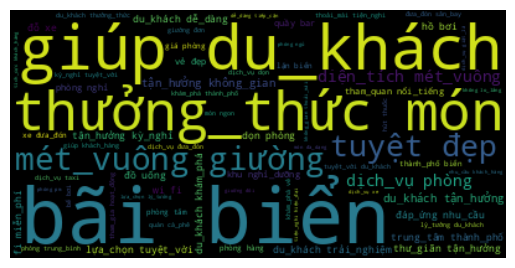

In [ ]:
content_text = " ".join(data_new['Content_wt'].astype(str))  # Nối các chuỗi lại thành một chuỗi duy nhất
wordcloud = WordCloud().generate(content_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
dictionary = corpora.Dictionary(data_new['Content_pre'])

In [ ]:
dictionary.token2id

{'_lộc_thọ': 0,
 '_tooth': 1,
 '_điều': 2,
 'agoda': 3,
 'amart': 4,
 'an_toàn': 5,
 'anh_thư': 6,
 'bao_gồm': 7,
 'bar': 8,
 'bay': 9,
 'beds': 10,
 'bia_tiệp': 11,
 'biển': 12,
 'buffet': 13,
 'bài_tập': 14,
 'bánh': 15,
 'bãi': 16,
 'bãi_biển': 17,
 'bóng_chuyền': 18,
 'bơi': 19,
 'bơi_lội': 20,
 'bạc': 21,
 'bắc_thành': 22,
 'bể': 23,
 'bỏ_qua': 24,
 'bồn': 25,
 'bữa': 26,
 'cam_kết': 27,
 'cam_ranh': 28,
 'central_park': 29,
 'cho_phép': 30,
 'chuon_chuon': 31,
 'chuyên_nghiệp': 32,
 'chuyến': 33,
 'chân': 34,
 'chùa': 35,
 'chú_ý': 36,
 'chăm_sóc': 37,
 'chất_lượng': 38,
 'chỗ': 39,
 'chợ': 40,
 'cuộc_sống': 41,
 'cà_phê': 42,
 'cá_sấu': 43,
 'cách_tiện': 44,
 'cát': 45,
 'công_cộng': 46,
 'công_sức': 47,
 'công_viên': 48,
 'công_viên_nước': 49,
 'căng_thẳng': 50,
 'cơ_sở': 51,
 'cảnh_quan': 52,
 'cửa_hàng': 53,
 'da': 54,
 'deluxe': 55,
 'deluxe_family': 56,
 'di_chuyển': 57,
 'diện_tích': 58,
 'double_bed': 59,
 'dr': 60,
 'du_khách': 61,
 'du_lịch': 62,
 'duy_trì': 63,
 'dạo':

In [ ]:
feature_cnt = len(dictionary.token2id)
feature_cnt

5515

In [ ]:
data_new['corpus'] = [dictionary.doc2bow(text) for text in data_new['Content_pre']]
data_new[['Hotel_ID','corpus']].head()

,Hotel_ID,corpus
0,1_1,"[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1..."
1,1_2,"[(2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (8, 3..."
2,1_3,"[(3, 1), (4, 1), (6, 1), (7, 1), (8, 1), (11, ..."
3,1_4,"[(3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1..."
4,1_5,"[(1, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1..."


## Dùng gensim

In [ ]:
# Use TF-IDF Model to process corpus, obtaining index
tfidf = models.TfidfModel(data_new['corpus'])
# tính toán sự tương tự trong ma trận thưa thớt
index = similarities.SparseMatrixSimilarity(tfidf[data_new['corpus']],
                                            num_features = feature_cnt)
# ma tran: n x n

In [ ]:
matrix_rcm = pd.DataFrame(index)
matrix_rcm

,0,1,2,3,4,5,6,7,8,9,...,576,577,578,579,580,581,582,583,584,585
0,1.000000,0.543255,0.500558,0.433984,0.502311,0.515954,0.407768,0.353455,0.383239,0.113631,...,0.103404,0.405689,0.111788,0.268175,0.079432,0.063980,0.020104,0.019775,0.083477,0.345736
1,0.543255,1.000000,0.572126,0.495506,0.552884,0.546911,0.457350,0.393041,0.430054,0.132783,...,0.098716,0.466426,0.087278,0.302616,0.078805,0.069822,0.023141,0.016630,0.093868,0.389040
2,0.500558,0.572126,1.000000,0.490507,0.543860,0.549642,0.435275,0.391226,0.433607,0.126896,...,0.099748,0.467171,0.107527,0.319594,0.085826,0.067135,0.023171,0.022840,0.112974,0.394848
3,0.433984,0.495506,0.490507,1.000000,0.494696,0.486979,0.345935,0.315308,0.393574,0.098291,...,0.074140,0.391196,0.090359,0.280645,0.073524,0.076665,0.023881,0.016919,0.087654,0.370583
4,0.502311,0.552884,0.543860,0.494696,1.000000,0.506292,0.411987,0.370829,0.415175,0.133216,...,0.104896,0.391847,0.096889,0.282062,0.078566,0.084331,0.026258,0.031323,0.124240,0.350933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,0.063980,0.069822,0.067135,0.076665,0.084331,0.060806,0.042188,0.068308,0.067103,0.145854,...,0.322132,0.072737,0.170833,0.084887,0.144544,1.000000,0.128664,0.077594,0.161889,0.089665
582,0.020104,0.023141,0.023171,0.023881,0.026258,0.019450,0.017733,0.024203,0.015431,0.091107,...,0.098163,0.039991,0.097657,0.043511,0.103892,0.128664,1.000000,0.062550,0.149208,0.023934
583,0.019775,0.016630,0.022840,0.016919,0.031323,0.015281,0.015846,0.011757,0.017733,0.083610,...,0.054714,0.036524,0.094668,0.012273,0.072313,0.077594,0.062550,1.000000,0.116687,0.016752
584,0.083477,0.093868,0.112974,0.087654,0.124240,0.085929,0.073869,0.072383,0.088692,0.282253,...,0.177002,0.092416,0.307151,0.062480,0.217560,0.161889,0.149208,0.116687,1.000000,0.066773


# Recommend gensim theo hotel_id

In [ ]:
def output_matrix_rcm(hotel_id):
  index_hotel_output = []

  hotel_corpus = data_new[data_new['Hotel_ID'] == hotel_id]['corpus']
  hotel_index = data_new[data_new['Hotel_ID'] == hotel_id]['Index']

  sim = index[tfidf[hotel_corpus]]
  sim = sim[0]

  # Xóa mẫu đang tìm trong sim
  arr = np.delete(sim, hotel_index)

  # Chỉnh lại in từ item có value cao -> thấp
  sim_sorted_desc = np.sort(arr)[::-1]

  # Lấy ra 5 phần tử đầu tiên -> 5 đề xuất khách sạn cao nhất
  max_rcm_5 = sim_sorted_desc[:5]

  # Index da duoc sap xep theo sim
  idx = np.argsort(sim)

  for i in range(5):
    if max_rcm_5[i] < 0.5:
      continue
    else:
      index_hotel_output.append(idx[i])

  index_hotel_output = np.sort(index_hotel_output)
  return data_recommend[['Hotel_Name', 'Hotel_Address']].iloc[index_hotel_output]

In [ ]:
idx = output_matrix_rcm('1_1')
idx

,Hotel_Name,Hotel_Address
125,"Nhà mặt đất 80 m² 3 phòng ngủ, 3 phòng tắm riê...","Tân Lập, Nha Trang, Việt Nam"
524,"Căn hộ 50 m² 2 phòng ngủ, 1 phòng tắm riêng ở ...","Lộc Thọ, Nha Trang, Việt Nam"
554,"Căn hộ 68 m² 2 phòng ngủ, 2 phòng tắm riêng ở ...","Xương Huân, Nha Trang, Việt Nam"
602,Căn hộ ở góc hướng biển (Seaview corner apartm...,"Vĩnh Phước, Nha Trang, Việt Nam"
706,"Nhà riêng 80 m² 2 phòng ngủ, 2 phòng tắm riêng...","Vĩnh Hiệp, Nha Trang, Việt Nam"


In [ ]:
pd.set_option('display.max_colwidth', None)  # Hiển thị toàn bộ nội dung cột
pd.reset_option('display.max_colwidth')

## Dùng cosine

In [ ]:
# Vector hóa nội dung
vectorizer = TfidfVectorizer(analyzer='word', stop_words=stopwords_lst)
tfidf_matrix = vectorizer.fit_transform(data_new['Content_wt'])

# Tính toán độ tương đồng
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
df_show = pd.DataFrame(cosine_sim)
df_show

,0,1,2,3,4,5,6,7,8,9,...,576,577,578,579,580,581,582,583,584,585
0,1.000000,0.767968,0.744208,0.690642,0.738231,0.715126,0.697994,0.639800,0.655716,0.313669,...,0.259190,0.645431,0.250965,0.572298,0.256732,0.172047,0.114764,0.073637,0.252949,0.612289
1,0.767968,1.000000,0.781714,0.729507,0.764717,0.748023,0.728410,0.656742,0.687588,0.320054,...,0.244483,0.693288,0.217346,0.586956,0.244475,0.169668,0.116914,0.073944,0.254944,0.637040
2,0.744208,0.781714,1.000000,0.723701,0.767368,0.751105,0.704869,0.673953,0.700669,0.318425,...,0.250208,0.696975,0.240423,0.606745,0.251133,0.164639,0.106038,0.082467,0.288373,0.638876
3,0.690642,0.729507,0.723701,1.000000,0.722509,0.722319,0.630791,0.596467,0.659584,0.290423,...,0.215650,0.636552,0.224407,0.558239,0.228577,0.184178,0.107969,0.079254,0.251332,0.621493
4,0.738231,0.764717,0.767368,0.722509,1.000000,0.716318,0.687115,0.638702,0.672936,0.315431,...,0.250551,0.632287,0.229427,0.562529,0.241223,0.185945,0.114769,0.087037,0.288228,0.603080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,0.172047,0.169668,0.164639,0.184178,0.185945,0.147978,0.139550,0.158457,0.160317,0.294367,...,0.526860,0.143006,0.306161,0.215542,0.288271,1.000000,0.263310,0.155106,0.281227,0.200908
582,0.114764,0.116914,0.106038,0.107969,0.114769,0.097373,0.107125,0.093949,0.092589,0.242443,...,0.222361,0.099053,0.231167,0.152229,0.259388,0.263310,1.000000,0.143587,0.284785,0.111160
583,0.073637,0.073944,0.082467,0.079254,0.087037,0.069307,0.072318,0.061004,0.079917,0.198993,...,0.140136,0.085994,0.210037,0.068589,0.186677,0.155106,0.143587,1.000000,0.233630,0.074885
584,0.252949,0.254944,0.288373,0.251332,0.288228,0.234088,0.240570,0.226823,0.247570,0.509502,...,0.369005,0.214804,0.525057,0.227996,0.444158,0.281227,0.284785,0.233630,1.000000,0.215665


## Recommend cosine theo hotel_id

In [ ]:
# Hàm đề xuất khách sạn
# # với mỗi sản phẩm, lấy nums sản phẩm tương quan nhất
def get_recommendations(hotel_id, cosine_sim=cosine_sim, nums=5):
    idx = data_new.index[data_new['Hotel_ID'] == hotel_id][0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:nums+1]  # Lấy 5 khách sạn tương tự nhất
    hotel_indices = [i[0] for i in sim_scores]
    return data_recommend.iloc[hotel_indices]

In [ ]:
# Gọi function
recommendations = get_recommendations('1_1')
recommendations

,Hotel_ID,Hotel_Name,Hotel_Description,Hotel_Address,Language,Index
49,2_20,Khách sạn V Nha Trang (V Hotel Nha Trang),Khách sạn V Nha Trang - Nơi lưu trú lý tưởng t...,"8 Hung Vuong, Lộc Thọ, Nha Trang, Việt Nam, 57000",vi,49
364,6_9,Angella Hotel Nha Trang,Khám phá Angella Hotel Nha Trang - Nơi lưu trú...,"11 Trần Hưng Đạo, Lộc Thọ, Nha Trang, Việt Nam",vi,322
226,19_16,Khách sạn Sochi (Sochi Hotel),Khách sạn Sochi - Nơi lưu trú lý tưởng tại Nha...,"96B/5/9 Tran Phu Street, Lộc Thọ, Nha Trang, V...",vi,213
37,2_8,Dubai Nha Trang Hotel,Dubai Nha Trang Hotel - Khách sạn 3.0 sao tại ...,"20 Tôn Đản, Phường Lộc Thọ, Thành Phố Nha Tran...",vi,37
626,8_15,Khách sạn Nhi Phi (Nhi Phi Hotel Nha Trang),Khách sạn Nhi Phi - Nơi lưu trú tuyệt vời tại ...,"10 Biệt Thự, Lộc Thọ, Nha Trang, Việt Nam",vi,500


## Lưu model

In [ ]:
# Save cosine_sim to file
import pickle
with open('cosine.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)

# Open and read file to cosine_new
with open('cosine.pkl', 'rb') as f:
    cosine_sim_new = pickle.load(f)
# cosine_sim_new

In [ ]:
def get_recommendations(df, hotel_id, cosine_sim=cosine_sim, nums=5):
    # Get the index of the hotel that matches the hotel_id
    matching_indices = df.index[df['Hotel_ID'] == hotel_id].tolist()
    if not matching_indices:
        print(f"No hotel found with ID: {hotel_id}")
        return pd.DataFrame()  # Return an empty DataFrame if no match
    idx = matching_indices[0]

    # Get the pairwise similarity scores of all hotels with that hotel
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the hotels based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar hotels (Ignoring the hotel itself)
    sim_scores = sim_scores[1:nums+1]

    # Get the hotel indices
    hotel_indices = [i[0] for i in sim_scores]

    # Return the top n most similar hotels as a DataFrame
    return df.iloc[hotel_indices]

In [ ]:
# Example usage (make sure to use a valid hotel_id from your DataFrame)
recommendations = get_recommendations(data_recommend[['Hotel_ID', 'Hotel_Name', 'Hotel_Address']], '1_1', cosine_sim=cosine_sim_new, nums=5)
recommendations

,Hotel_ID,Hotel_Name,Hotel_Address
49,2_20,Khách sạn V Nha Trang (V Hotel Nha Trang),"8 Hung Vuong, Lộc Thọ, Nha Trang, Việt Nam, 57000"
364,6_9,Angella Hotel Nha Trang,"11 Trần Hưng Đạo, Lộc Thọ, Nha Trang, Việt Nam"
226,19_16,Khách sạn Sochi (Sochi Hotel),"96B/5/9 Tran Phu Street, Lộc Thọ, Nha Trang, V..."
37,2_8,Dubai Nha Trang Hotel,"20 Tôn Đản, Phường Lộc Thọ, Thành Phố Nha Tran..."
626,8_15,Khách sạn Nhi Phi (Nhi Phi Hotel Nha Trang),"10 Biệt Thự, Lộc Thọ, Nha Trang, Việt Nam"
